In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import os
import pickle
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
import yfinance as yf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
# meat production vs. future percent change in stock price
# cold storage vs. measure of healthy/obesity
# stratify by location/race

In [4]:
path = "/content/drive/MyDrive/Datathon Data/"

In [5]:
# Stocks
STOCKS = pd.read_csv(path + "all_stock_and_etfs.csv")
STOCK_DES = pd.read_csv(path + "stock_descriptions.csv")

# Meat
WEIGHT = pd.read_csv(path + "Meat_Stats_Slaughter_Weights.csv")
PROD = pd.read_csv(path + "Meat_Stats_Meat_Production.csv")
COUNT = pd.read_csv(path + "Meat_Stats_Slaughter_Counts.csv")
STORAGE = pd.read_csv(path + "Meat_Stats_Cold_Storage.csv")
# Commodities
COMM = pd.read_csv(path + "all_commodities.csv")

# health/survey/economic data
NUTRITION = pd.read_csv(path + "Nutrition_Physical_Activity_and_Obesity_Data.csv")
ECON = pd.read_csv(path + "acs_5yr_est_selected_economic_characteristics_2010-2022.csv")

<ipython-input-5-7c87edb32129>:14: DtypeWarning: Columns (18,19,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  NUTRITION = pd.read_csv(path + "Nutrition_Physical_Activity_and_Obesity_Data.csv")


In [6]:
def string_to_float(x):
  if type(x) == float:
    return x
  if x != x: # nan
    return None
  return float(x.replace(",", ""))

In [7]:
def percent_to_float(string):
  if type(string) != str:
    return np.nan
  if not "%" in string:
    return np.nan
  return float(string.replace("%", ""))

In [8]:
PROD["Production"] = PROD["Production"].apply(string_to_float)
COUNT["Count"] = COUNT["Count"].apply(string_to_float)
WEIGHT["Weight"] = WEIGHT["Weight"].apply(string_to_float)

STOCKS["Date-Time"] = pd.to_datetime(STOCKS["Date-Time"])
STORAGE["Date"] = pd.to_datetime(STORAGE["Date"])
WEIGHT["Date"] = pd.to_datetime(WEIGHT["Date"])
PROD["Date"] = pd.to_datetime(PROD["Date"])
COUNT["Date"] = pd.to_datetime(COUNT["Date"])
COMM["Date-Time"] = pd.to_datetime(COMM["Date-Time"])

ECON["Label (Grouping)"] = ECON["Label (Grouping)"].apply(lambda x: x.strip())
ECON["Percent"] = ECON["Percent"].apply(percent_to_float)

<ipython-input-8-208e169789f4>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  STORAGE["Date"] = pd.to_datetime(STORAGE["Date"])
<ipython-input-8-208e169789f4>:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  WEIGHT["Date"] = pd.to_datetime(WEIGHT["Date"])
<ipython-input-8-208e169789f4>:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  PROD["Date"] = pd.to_datetime(PROD["Date"])
<ipython-input-8-208e169789f4>:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, pleas

# Organizing Meat Data

In [9]:
global_animals = ["Beef", "Calves", "Pork", "Lamb", "Broiler", "Other Chicken", "Turkey"]

prod_animals = ["Beef", "Veal", "Pork", "Lamb and Mutton", "Broilers", "Other Chicken", "Turkey"]
weight_animals = ["Cattle", "Calves", "Hogs", "Sheep and Lambs", "Broilers", "Other Chickens", "Turkeys"]
storage_animals = ["Beef", "Veal", "Pork", "Lamb and Mutton", "Broiler", "Other Chicken", "Turkey"]
counts_animals = [["Cattle", "Steers", "Heifers", "Beef Cows", "Bulls and Stags"], ["Calves"],
                  ["Hogs", "Barrows and Gilts", "Boars and Stags"], ["Sheep and Lambs", "Lambs and Yearlings", "Mature Sheep"],
                  ["Broilers"], ["Other chickens"], ["Turkeys"]]

meat_animals = [prod_animals, weight_animals, storage_animals, counts_animals]
for i in meat_animals:
  assert len(i) == len(global_animals)

In [10]:
PROD_dict = {}
for i in range(len(prod_animals)):
  print("Processing {} Data".format(prod_animals[i]))
  df_animal = PROD[(PROD["Animal"] == prod_animals[i]) & (PROD["Commercial or Federally Inspected"] == "Federally Inspected")][["Date", "Production"]]
  df_animal.set_index("Date", inplace=True)
  df_animal.sort_index(inplace=True)
  print("{} NaN values".format(df_animal["Production"].isnull().sum()))
  PROD_dict[global_animals[i]] = df_animal

Processing Beef Data
236 NaN values
Processing Veal Data
236 NaN values
Processing Pork Data
236 NaN values
Processing Lamb and Mutton Data
236 NaN values
Processing Broilers Data
468 NaN values
Processing Other Chicken Data
959 NaN values
Processing Turkey Data
469 NaN values


In [11]:
# Weight has no NaNs, we are dividing federally inspected dressed by federally inspected live and extracting these values

In [12]:
WEIGHT_dict = {}
for i in range(len(weight_animals)):
  print("Processing {} Data".format(weight_animals[i]))
  df_dressed = WEIGHT[(WEIGHT["Animal"] == weight_animals[i]) &
                     (WEIGHT["Commercial_Or_Federally_Inspected"] == "Federally Inspected") &
                     (WEIGHT["Live_Or_Dressed"] == "Dressed")][["Date", "Weight"]]
  df_live = WEIGHT[(WEIGHT["Animal"] == weight_animals[i]) &
                     (WEIGHT["Commercial_Or_Federally_Inspected"] == "Federally Inspected") &
                     (WEIGHT["Live_Or_Dressed"] == "Live")][["Date", "Weight"]]
  if df_dressed["Weight"].shape[0] == 0:
    WEIGHT_dict[global_animals[i]] = None
    print("No data for {}".format(global_animals[i]))
    continue
  df_animal = pd.DataFrame({"Date": df_live["Date"], "WeightRatio": df_dressed["Weight"].values / df_live["Weight"].values})
  df_animal.set_index("Date", inplace=True)
  df_animal.sort_index(inplace=True)
  print("{} NaN values".format(df_animal["WeightRatio"].isnull().sum()))
  WEIGHT_dict[global_animals[i]] = df_animal

Processing Cattle Data
0 NaN values
Processing Calves Data
0 NaN values
Processing Hogs Data
0 NaN values
Processing Sheep and Lambs Data
0 NaN values
Processing Broilers Data
No data for Broiler
Processing Other Chickens Data
No data for Other Chicken
Processing Turkeys Data
No data for Turkey


In [13]:
STORAGE_dict = {}
for i in range(len(storage_animals)):
  print("Processing {} Data".format(storage_animals[i]))
  df_animal = STORAGE[STORAGE["Animal"] == storage_animals[i]][["Date", "Weight"]]
  df_animal.set_index("Date", inplace=True)
  df_animal.sort_index(inplace=True)
  print("{} NaN values".format(df_animal["Weight"].isnull().sum()))
  STORAGE_dict[global_animals[i]] = df_animal

Processing Beef Data
0 NaN values
Processing Veal Data
0 NaN values
Processing Pork Data
0 NaN values
Processing Lamb and Mutton Data
0 NaN values
Processing Broiler Data
245 NaN values
Processing Other Chicken Data
0 NaN values
Processing Turkey Data
0 NaN values


In [14]:
COUNT_dict = {}
for i in range(len(counts_animals)):
  print("Processing {} Data".format(global_animals[i]))
  df_temp = pd.DataFrame({"Date": COUNT[COUNT["Animal"] == counts_animals[i][0]]["Date"].iloc[:493], "Count": np.zeros((493))})
  for j in range(len(counts_animals[i])):
    print("\tProcessing {} Data".format(counts_animals[i][j]))
    df_animal = COUNT[(COUNT["Animal"] == counts_animals[i][j]) &
                      (COUNT["Commercial_Or_Federally_Inspected"] == "Federally Inspected")]["Count"]
    df_temp["Count"] += df_animal.values
    print("\t{} NaN values".format(df_temp["Count"].isnull().sum()))
  df_temp.set_index("Date", inplace=True)
  df_temp.sort_index(inplace=True)
  COUNT_dict[global_animals[i]] = df_temp

Processing Beef Data
	Processing Cattle Data
	0 NaN values
	Processing Steers Data
	0 NaN values
	Processing Heifers Data
	0 NaN values
	Processing Beef Cows Data
	0 NaN values
	Processing Bulls and Stags Data
	0 NaN values
Processing Calves Data
	Processing Calves Data
	0 NaN values
Processing Pork Data
	Processing Hogs Data
	0 NaN values
	Processing Barrows and Gilts Data
	0 NaN values
	Processing Boars and Stags Data
	0 NaN values
Processing Lamb Data
	Processing Sheep and Lambs Data
	0 NaN values
	Processing Lambs and Yearlings Data
	0 NaN values
	Processing Mature Sheep Data
	0 NaN values
Processing Broiler Data
	Processing Broilers Data
	0 NaN values
Processing Other Chicken Data
	Processing Other chickens Data
	217 NaN values
Processing Turkey Data
	Processing Turkeys Data
	0 NaN values


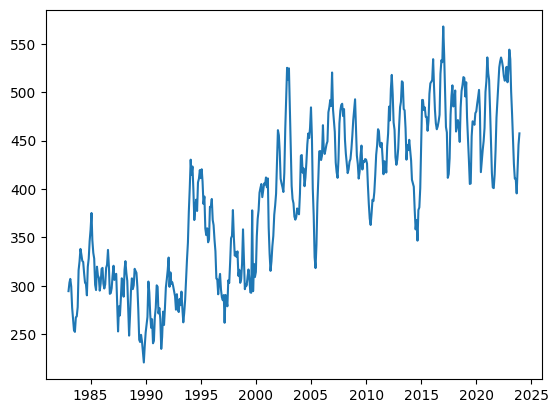

In [15]:
plt.plot(STORAGE_dict["Beef"])
plt.show()

In [16]:
def plot_meat_stuff():
  prod_df = pd.concat([val for val in PROD_dict.values()], keys = list(PROD_dict.keys()), axis = 1)
  prod_df = prod_df.droplevel(1, axis=1)
  prod_df = prod_df.rolling(10).mean()
  prod_plot = px.line(prod_df)

  weight_df = pd.concat([val for val in WEIGHT_dict.values()], keys = list(WEIGHT_dict.keys()), axis = 1)
  weight_df = weight_df.droplevel(1, axis=1)
  weight_df = weight_df.rolling(10).mean()
  weight_plot = px.line(weight_df)

  storage_df = pd.concat([val for val in STORAGE_dict.values()], keys = list(STORAGE_dict.keys()), axis = 1)
  storage_df = storage_df.droplevel(1, axis=1)
  storage_df = storage_df.rolling(10).mean()
  storage_plot = px.line(storage_df)

  count_df = pd.concat([val for val in COUNT_dict.values()], keys = list(COUNT_dict.keys()), axis = 1)
  count_df = count_df.droplevel(1, axis=1)
  count_df = count_df.rolling(10).mean()
  count_plot = px.line(count_df)

  prod_plot.show()
  weight_plot.show()
  storage_plot.show()
  count_plot.show()

  return prod_plot, weight_plot, storage_plot, count_plot

prod_plot, weight_plot, storage_plot, count_plot = plot_meat_stuff()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/

In [17]:
pip install -U kaleido

In [18]:
weight_plot.write_image("weight_ratio.png", scale=6)

In [19]:
storage_plot.write_image("meat_storage.png", scale=6)

# Organizing Stock Data

In [20]:
trade_service_tickers = list(STOCK_DES[STOCK_DES["Sector"] == "TRADE & SERVICES"]["Symbol"])
tech_tickers = list(STOCK_DES[STOCK_DES["Sector"] == "TECHNOLOGY"]["Symbol"])
manufac_tickers = list(STOCK_DES[STOCK_DES["Sector"] == "MANUFACTURING"]["Symbol"])
etf_tickers = list(STOCK_DES[STOCK_DES["Sector"] == "MULTIPLE"]["Symbol"])

In [21]:
def stock_price_history(ticker):
  # Use Yahoo Finance instead of provided data because of unaccounted stock splits
  stock_data = yf.Ticker(ticker).history(period="max")
  if stock_data.shape[0] == 0:
    return None
  stock_data.index = stock_data.index.strftime('%Y-%m-%d')
  stock_data.index = pd.to_datetime(stock_data.index)
  return stock_data[["Open", "High", "Low", "Close", "Volume"]]

# def stock_price_history(ticker):
#   # Columns: [Open, High, Low, Close, Volume]
#   history = STOCKS[STOCKS["Ticker_Symbol"] == ticker].iloc[::-1]
#   history.set_index("Date-Time", inplace=True)
#   return history.iloc[:,:-1]

In [22]:
all_tickers = STOCKS["Ticker_Symbol"].unique()
all_stock_data = {ticker: stock_price_history(ticker) for ticker in all_tickers}
all_stock_data = {key: value for key, value in all_stock_data.items() if value is not None}

ERROR:yfinance:$CNHI: possibly delisted; No timezone found


In [23]:
def run_granger_causality(x, y, maxlag=15, reverse=False):
  assert x.shape[0] == y.shape[0]
  x = x.diff().dropna()
  y = y.diff().dropna()

  # Dicker-Fuller test to check for stationarity
  # print(adfuller(x)[1])
  # print(adfuller(y)[1])
  if reverse:
    df = pd.concat([y.reset_index(drop=True), x.reset_index(drop=True)], axis=1)
  else:
    df = pd.concat([x.reset_index(drop=True), y.reset_index(drop=True)], axis=1)
  results_dict = grangercausalitytests(df, maxlag=maxlag)
  avg_pvals = {lag: np.mean([value[1] for key, value in results_dict[lag][0].items()]) for lag in range(1, maxlag + 1)}
  # returns a dictionary with lag times as keys and average p values from the 4 significance tests as values
  return avg_pvals

In [24]:
def join_by_month(df1, df2):
  # df1.index = df1.index.strftime("%Y-%m")
  # df1.index = pd.to_datetime(df1.index)
  # df2.index = df2.index.strftime("%Y-%m")
  # df2.index = pd.to_datetime(df2.index)
  df1 = pd.DataFrame(df1)
  df2 = pd.DataFrame(df2)
  df1["Year"] = df1.index.year
  df1["Month"] = df1.index.month
  df2["Year"] = df2.index.year
  df2["Month"] = df2.index.month
  merged = pd.merge(df1, df2, on=["Year", "Month"])
  merged["Date"] = pd.to_datetime(merged[["Year", "Month"]].assign(day=1))
  merged.set_index("Date", inplace=True)
  merged.drop(["Year", "Month"], axis=1, inplace=True)
  return merged

In [25]:
best_lag_times = {} # meat production causes stock movement
best_lag_times_rev = {} # stock movement causes meat production
for ticker, data in all_stock_data.items():
  print(ticker)
  monthly_average = data.resample("M").mean()
  granger_input = join_by_month(monthly_average["Close"], PROD_dict["Beef"][PROD_dict["Beef"].index > "1983"])
  results = run_granger_causality(granger_input.iloc[:,0], granger_input.iloc[:,1])
  # print("Best Lag Time: {}, p-value: {}".format(min(results, key=results.get), min(results.values())))
  results_rev = run_granger_causality(granger_input.iloc[:,0], granger_input.iloc[:,1], reverse=True)
  best_lag_times[ticker] = (min(results, key=results.get), min(results.values()))
  best_lag_times_rev[ticker] = (min(results_rev, key=results_rev.get), min(results_rev.values()))

Streaming output truncated to the last 5000 lines.

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.6155  , p=0.8003  , df_denom=280, df_num=10
ssr based chi2 test:   chi2=6.6169  , p=0.7610  , df=10
likelihood ratio test: chi2=6.5452  , p=0.7676  , df=10
parameter F test:         F=0.6155  , p=0.8003  , df_denom=280, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=0.5733  , p=0.8500  , df_denom=277, df_num=11
ssr based chi2 test:   chi2=6.8302  , p=0.8127  , df=11
likelihood ratio test: chi2=6.7536  , p=0.8187  , df=11
parameter F test:         F=0.5733  , p=0.8500  , df_denom=277, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=0.9575  , p=0.4901  , df_denom=274, df_num=12
ssr based chi2 test:   chi2=12.5377 , p=0.4035  , df=12
likelihood ratio test: chi2=12.2820 , p=0.4233  , df=12
parameter F test:         F=0.9575  , p=0.4901  , df_denom=274, df_num=12

Granger Causality
number of

In [26]:
best_lag_times

{'HRL': (5, 0.003787514310744703),
 'VOO': (1, 0.04136015897781284),
 'ADM': (8, 0.6106042319183285),
 'AGCO': (11, 0.15854881899590656),
 'DIA': (1, 0.1505897824214557),
 'PEP': (11, 0.0009375892992238158),
 'QSR': (14, 0.06081157469972231),
 'TSCO': (15, 0.0496314207086833),
 'ONEQ': (1, 0.04363005781762756),
 'PPC': (3, 0.1760099448238085),
 'CAG': (1, 0.05728276464232958),
 'DRI': (14, 0.18888178680701428),
 'HSY': (11, 0.021344105460456612),
 'CAT': (1, 0.5376028451773537),
 'SBUX': (3, 0.0016574327580040223),
 'CMG': (14, 0.07968886703756806),
 'COKE': (1, 0.5665954861098994),
 'SPY': (1, 0.027717666769972876),
 'DE': (14, 0.06709817638286657),
 'TSN': (12, 0.04562121033004991),
 'GIS': (1, 0.14066605229009999),
 'WEN': (12, 0.04467697104651015),
 'YUM': (4, 0.01830587527574759),
 'VMI': (2, 0.19030090646941694),
 'MCD': (5, 0.010318558850251777),
 'SAP': (15, 0.03536123594952057),
 'DPZ': (1, 0.041407449694092324),
 'ALG': (15, 0.21706847987250882)}

In [27]:
best_lag_times_rev

{'HRL': (12, 0.012305632133017256),
 'VOO': (2, 0.016203463624983795),
 'ADM': (14, 0.011898249088514404),
 'AGCO': (14, 0.012971501894100785),
 'DIA': (14, 9.463887220824614e-05),
 'PEP': (15, 0.009816015844088229),
 'QSR': (2, 0.0015289998965776414),
 'TSCO': (10, 0.04562827955534465),
 'ONEQ': (14, 0.0010778349684250736),
 'PPC': (2, 0.008581229416653935),
 'CAG': (15, 4.281754733868666e-05),
 'DRI': (13, 1.4142869539575421e-06),
 'HSY': (10, 2.4092556911724486e-05),
 'CAT': (14, 0.2819389554393204),
 'SBUX': (11, 0.0008664317788788658),
 'CMG': (2, 0.024663142439540455),
 'COKE': (13, 0.010105324566508284),
 'SPY': (14, 2.589126015363443e-05),
 'DE': (14, 0.03498375401018264),
 'TSN': (9, 8.548110542180308e-07),
 'GIS': (14, 0.07331557330366631),
 'WEN': (14, 0.0016233690333202105),
 'YUM': (15, 0.001869249403050861),
 'VMI': (14, 0.05230150868742184),
 'MCD': (14, 1.7262282913391484e-07),
 'SAP': (14, 0.0020867704648648744),
 'DPZ': (14, 0.0038805901249588165),
 'ALG': (14, 5.4546

In [28]:
# KDP, MNST are in metadata but there's no data for them in the actual stock data

# Econ Stuff

In [29]:
headers = ECON[ECON["Category"] == "Header"]["Label (Grouping)"].unique()
headers

array(['EMPLOYMENT STATUS', 'COMMUTING TO WORK', 'OCCUPATION', 'INDUSTRY',
       'CLASS OF WORKER',
       'INCOME AND BENEFITS (IN 2010 INFLATION-ADJUSTED DOLLARS)',
       'HEALTH INSURANCE COVERAGE',
       'PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL',
       'INCOME AND BENEFITS (IN 2011 INFLATION-ADJUSTED DOLLARS)',
       'INCOME AND BENEFITS (IN 2013 INFLATION-ADJUSTED DOLLARS)',
       'INCOME AND BENEFITS (IN 2012 INFLATION-ADJUSTED DOLLARS)',
       'INCOME AND BENEFITS (IN 2016 INFLATION-ADJUSTED DOLLARS)',
       'INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS)',
       'INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)',
       'INCOME AND BENEFITS (IN 2014 INFLATION-ADJUSTED DOLLARS)',
       'INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)',
       'INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS)',
       'INCOME AND BENEFITS (IN 2022 INFLATION-ADJUSTED DOLLARS)',
       'INCOME AND B

In [30]:
category = "PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL"
social_groups = ["Married couple families", "Families with female householder, no husband present"]
poverty_dict = {social_groups[i]: ECON[(ECON["Category"] == category) & (ECON["Label (Grouping)"] == social_groups[i])][["State", "Percent", "Year"]].set_index("Year").sort_values(by=["Year", "State"])
                for i in range(len(social_groups))}
for key, value in poverty_dict.items():
  if(poverty_dict[key]['Percent'].dtype != 'float64'):
    poverty_dict[key]["Percent"] = poverty_dict[key]["Percent"].apply(percent_to_float)

if(poverty_dict[key]['Percent'].dtype != 'float64'):
  poverty_dict = {key: value["Percent"].apply(percent_to_float) for key, value in poverty_dict.items()}

In [31]:
health_dict = ECON[(ECON["Category"] == "HEALTH INSURANCE COVERAGE") & (ECON["Label (Grouping)"] == "With health insurance coverage")][["State", "Estimate", "Percent", "Year"]]
health_dict = health_dict.groupby(["Year", "State"])["Percent"].mean().reset_index().set_index("Year")
health_dict

,State,Percent
Year,,
2010,Alabama,NaN
2010,Alaska,NaN
2010,Arizona,NaN
2010,Arkansas,NaN
2010,California,NaN
...,...,...
2022,Virginia,86.600
2022,Washington,88.750
2022,West Virginia,87.925


In [32]:
px.line(health_dict, y="Percent", color="State")

In [33]:
ECON[(ECON["Category"] == "HEALTH INSURANCE COVERAGE")]["Label (Grouping)"].unique()

array(['Civilian noninstitutionalized population',
       'With health insurance coverage', 'With private health insurance',
       'With public coverage', 'No health insurance coverage',
       'Civilian noninstitutionalized population under 18 years',
       'Civilian noninstitutionalized population 18 to 64 years',
       'In labor force:', 'Employed:', 'Unemployed:',
       'Not in labor force:',
       'Civilian noninstitutionalized population under 19 years',
       'Civilian noninstitutionalized population 19 to 64 years'],
      dtype=object)

In [34]:
states = list(ECON["State"].unique())
assert len(states) == 52

In [35]:
ln = px.line(poverty_dict[social_groups[0]], y = "Percent", color = "State")
ln.show()

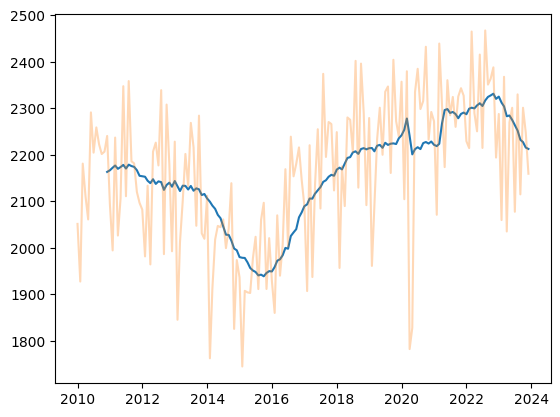

In [36]:
plt.plot(PROD_dict["Beef"][PROD_dict["Beef"].index >= "2010"].rolling(12).mean())
plt.plot(PROD_dict["Beef"][PROD_dict["Beef"].index >= "2010"], alpha=0.3)
plt.show()

In [37]:
poverty_dict[social_groups[0]][poverty_dict[social_groups[0]]["State"] == states[0]]["Percent"].pct_change()

,Percent
Year,
2010,NaN
2011,0.053571
2012,0.050847
2013,0.016129
2014,0.015873
2015,0.000000
2016,-0.031250
2017,-0.048387
2018,-0.016949


In [38]:
STORAGE_dict["Beef"][(STORAGE_dict["Beef"].index >= "2010") & (STORAGE_dict["Beef"].index <= "2022")].resample("Y").mean().pct_change()

,Weight
Date,
2010-12-31,NaN
2011-12-31,0.103185
2012-12-31,0.061482
2013-12-31,0.011224
2014-12-31,-0.169404
2015-12-31,0.233140
2016-12-31,0.028784
2017-12-31,-0.034182
2018-12-31,0.011476


In [39]:
# There is moderate negative correlation between beef production and counts and unemployment (across most states) in families
# This negative correlation is more pronounced in single family households

In [40]:
beef_unemployment_dict = {}
for i in range(len(states)):
  # fig, ax1 = plt.subplots()

  # color = 'tab:red'
  # ax1.set_xlabel('Year')
  # ax1.set_ylabel('unemployment rate', color=color)
  # ax1.plot(np.arange(2010,2023), poverty_dict[social_groups[0]][poverty_dict[social_groups[0]]["State"] == states[i]]["Percent"], color=color)
  # ax1.tick_params(axis='y', labelcolor=color)

  # ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

  # color = 'tab:blue'
  # ax2.set_ylabel('beef storage (million lb)', color=color)  # we already handled the x-label with ax1
  # ax2.plot(np.arange(2010,2023), STORAGE_dict["Beef"][(STORAGE_dict["Beef"].index >= "2010") & (STORAGE_dict["Beef"].index <= "2022")].resample("Y").mean(), color=color)
  # ax2.tick_params(axis='y', labelcolor=color)

  # fig.tight_layout()  # otherwise the right y-label is slightly clipped
  # ax1.set_title(states[i])
  # plt.show()

  # This is important
  x = pd.DataFrame(poverty_dict[social_groups[1]][poverty_dict[social_groups[1]]["State"] == states[i]]["Percent"].pct_change().dropna())
  y = PROD_dict["Beef"][(PROD_dict["Beef"].index >= "2010") & (PROD_dict["Beef"].index <= "2022")].resample("Y").mean().pct_change().dropna()
  # plt.scatter(x, y)
  # plt.show()
  correlation = x.reset_index(drop=True)["Percent"].corr(y.reset_index(drop=True)["Production"])
  print("{}: {}".format(states[i], correlation))
  beef_unemployment_dict[states[i]] = correlation

Alabama: -0.7582973451971652
Alaska: 0.3345539654338061
Arizona: -0.7126863920349354
Arkansas: -0.6037413115476085
California: -0.6474473890087291
Colorado: -0.41189086862239577
Connecticut: -0.6574151976308361
Delaware: -0.6753639978228292
District of Columbia: 0.24928191220516366
Florida: -0.6831726551850239
Georgia: -0.6104328476278459
Hawaii: -0.3822053022803841
Idaho: -0.5977244862273695
Illinois: -0.7878077807991252
Indiana: -0.6922550840671091
Iowa: -0.6624060604405523
Kansas: -0.4390264240974549
Kentucky: -0.331315919145279
Louisiana: -0.5329636346032117
Maine: -0.8869590416594875
Maryland: -0.605386645792978
Massachusetts: -0.6408699073329726
Michigan: -0.606477420792625
Minnesota: -0.6197922758758884
Mississippi: -0.1277582298545213
Missouri: -0.6604722095549777
Montana: -0.6041737677201193
Nebraska: -0.801298972230896
Nevada: -0.5496420539922523
New Hampshire: -0.4784709746403634
New Jersey: -0.3939368293154358
New Mexico: -0.6447055898678703
New York: -0.7541106292023346
No

In [41]:
beef_unemployment_dict

{'Alabama': -0.7582973451971652,
 'Alaska': 0.3345539654338061,
 'Arizona': -0.7126863920349354,
 'Arkansas': -0.6037413115476085,
 'California': -0.6474473890087291,
 'Colorado': -0.41189086862239577,
 'Connecticut': -0.6574151976308361,
 'Delaware': -0.6753639978228292,
 'District of Columbia': 0.24928191220516366,
 'Florida': -0.6831726551850239,
 'Georgia': -0.6104328476278459,
 'Hawaii': -0.3822053022803841,
 'Idaho': -0.5977244862273695,
 'Illinois': -0.7878077807991252,
 'Indiana': -0.6922550840671091,
 'Iowa': -0.6624060604405523,
 'Kansas': -0.4390264240974549,
 'Kentucky': -0.331315919145279,
 'Louisiana': -0.5329636346032117,
 'Maine': -0.8869590416594875,
 'Maryland': -0.605386645792978,
 'Massachusetts': -0.6408699073329726,
 'Michigan': -0.606477420792625,
 'Minnesota': -0.6197922758758884,
 'Mississippi': -0.1277582298545213,
 'Missouri': -0.6604722095549777,
 'Montana': -0.6041737677201193,
 'Nebraska': -0.801298972230896,
 'Nevada': -0.5496420539922523,
 'New Hampshire

In [42]:
ECON

,Label (Grouping),Category,State,Estimate,Margin of Error,Percent,Percent Margin of Error,Year
0,EMPLOYMENT STATUS,Header,Alabama,NaN,NaN,NaN,NaN,2010
1,Population 16 years and over,EMPLOYMENT STATUS,Alabama,"3,714,504","±1,588",NaN,(X),2010
2,In labor force,EMPLOYMENT STATUS,Alabama,"2,246,848","±5,576",60.5,±0.1,2010
3,Civilian labor force,EMPLOYMENT STATUS,Alabama,"2,230,879","±5,531",60.1,±0.1,2010
4,Employed,EMPLOYMENT STATUS,Alabama,"2,036,867","±5,904",54.8,±0.2,2010
...,...,...,...,...,...,...,...,...
98015,18 years and over,PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME...,Puerto Rico,(X),(X),39.7,±0.4,2021
98016,18 to 64 years,PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME...,Puerto Rico,(X),(X),40.1,±0.4,2021
98017,65 years and over,PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME...,Puerto Rico,(X),(X),38.5,±0.5,2021
98018,People in families,PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME...,Puerto Rico,(X),(X),40.0,±0.4,2021


In [43]:
state_abbreviations = [
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA',
    'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK',
    'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'PR'
]

In [44]:
import plotly.express as px

df = pd.DataFrame(beef_unemployment_dict.items(), columns=["State", "Corr"])
fig = px.choropleth(df,
                    locations=state_abbreviations,
                    locationmode='USA-states',
                    color='Corr',
                    hover_name='State',
                    scope='usa',
                    labels={'Corr': 'Corr'},
                    title='Choropleth Map of All States Plus DC')

# # Add Puerto Rico manually
# fig.add_choropleth(locations=['PR'],
#                    locationmode='USA-states',
#                    z=[df[df['State'] == 'Puerto Rico']['Corr'].values[0]],
#                    colorscale='Viridis')

fig.show()


In [45]:
import plotly.express as px

df = pd.DataFrame(beef_unemployment_dict.items(), columns=["State", "Corr"])
fig = px.choropleth(df,
                    locations=state_abbreviations,
                    locationmode='USA-states',
                    color='Corr',
                    hover_name='State',
                    scope='usa',
                    labels={'Corr': 'Corr'},
                    title='Choropleth Map of All States Plus DC')

# # Add Puerto Rico manually
# fig.add_choropleth(locations=['PR'],
#                    locationmode='USA-states',
#                    z=[df[df['State'] == 'Puerto Rico']['Corr'].values[0]],
#                    colorscale='Viridis')

fig.show()


In [46]:
income = (temp.groupby(["Year", "State"]).sum() / 2).reset_index().set_index("Year")
px.line(income, y="Percent", color="State")

NameError: name 'temp' is not defined

In [ ]:
beefstorage_income_dict = {}
for i in range(len(states)):
  x = income[income["State"] == states[i]]["Percent"].pct_change().dropna()
  y = STORAGE_dict["Beef"].resample("Y").mean().rolling(3).mean().pct_change().dropna()
  y = y[(y.index >= "2010") & (y.index <= "2022")]
  # plt.scatter(x, y)
  # plt.show()
  correlation = x.reset_index(drop=True).corr(y.reset_index(drop=True)["Weight"])
  print("{}: {}".format(states[i], correlation))
  beefstorage_income_dict[states[i]] = correlation

In [ ]:
df = pd.DataFrame(beefstorage_income_dict.items(), columns=["State", "Corr"])
fig = px.choropleth(df,
                    locations=state_abbreviations,
                    locationmode='USA-states',
                    color='Corr',
                    hover_name='State',
                    scope='usa',
                    labels={'Corr': 'Corr'},
                    title='Choropleth Map of All States Plus DC')
fig.show()

# Health

In [47]:
NUTRITION[NUTRITION["Class"] == "Obesity / Weight Status"]["Question"].unique()

array(['Percent of students in grades 9-12 who have obesity',
       'Percent of students in grades 9-12 who have an overweight classification',
       'Percent of adults aged 18 years and older who have obesity',
       'Percent of adults aged 18 years and older who have an overweight classification'],
      dtype=object)

In [48]:
NUTRITION.columns

Index(['YearStart', 'YearEnd', 'LocationAbbr', 'LocationDesc', 'Datasource',
       'Class', 'Topic', 'Question', 'Data_Value_Unit', 'Data_Value_Type',
       'Data_Value', 'Data_Value_Alt', 'Data_Value_Footnote_Symbol',
       'Data_Value_Footnote', 'Low_Confidence_Limit', 'High_Confidence_Limit',
       'Sample_Size', 'Total', 'Age(years)', 'Education', 'Gender', 'Grade',
       'Income', 'Race/Ethnicity', 'GeoLocation', 'ClassID', 'TopicID',
       'QuestionID', 'DataValueTypeID', 'LocationID',
       'StratificationCategory1', 'Stratification1',
       'StratificationCategoryId1', 'StratificationID1'],
      dtype='object')

In [49]:
obesity_questions = NUTRITION[NUTRITION["Class"] == "Obesity / Weight Status"]["Question"].unique()

In [50]:
races = ["American Indian/Alaska Native", "Hispanic", "Non-Hispanic White", "Hawaiian/Pacific Islander", "Asian", "Non-Hispanic Black"]

In [51]:
obesity_data = {}
for q in obesity_questions:
  for r in races:
    temp = NUTRITION[(NUTRITION["Question"] == q) & (NUTRITION["Stratification1"] == r)][["YearStart", "LocationAbbr", "Data_Value"]]
    temp = temp.sort_values(["YearStart", "LocationAbbr"])
    temp.set_index("YearStart", inplace=True)
    if not q in obesity_data.keys():
      obesity_data[q] = {}
    obesity_data[q][r] = temp

In [52]:
obesity_questions[1]

'Percent of students in grades 9-12 who have an overweight classification'

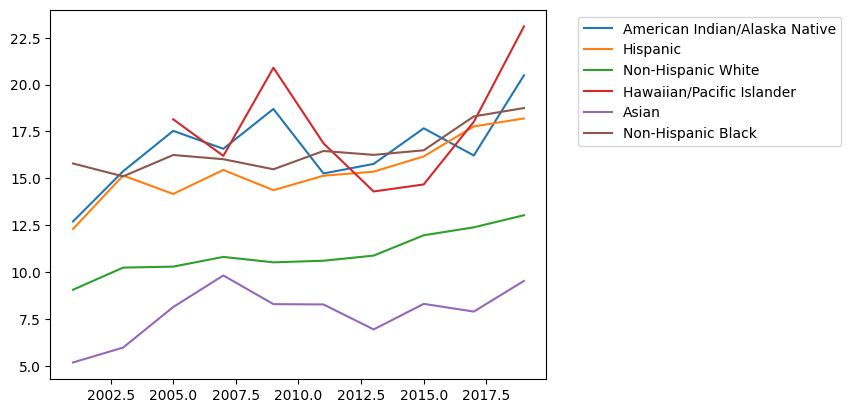

In [53]:
for r in races:
  plt.plot(obesity_data[obesity_questions[0]][r].groupby("YearStart")["Data_Value"].mean(), label=r)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [54]:
NUTRITION.columns

Index(['YearStart', 'YearEnd', 'LocationAbbr', 'LocationDesc', 'Datasource',
       'Class', 'Topic', 'Question', 'Data_Value_Unit', 'Data_Value_Type',
       'Data_Value', 'Data_Value_Alt', 'Data_Value_Footnote_Symbol',
       'Data_Value_Footnote', 'Low_Confidence_Limit', 'High_Confidence_Limit',
       'Sample_Size', 'Total', 'Age(years)', 'Education', 'Gender', 'Grade',
       'Income', 'Race/Ethnicity', 'GeoLocation', 'ClassID', 'TopicID',
       'QuestionID', 'DataValueTypeID', 'LocationID',
       'StratificationCategory1', 'Stratification1',
       'StratificationCategoryId1', 'StratificationID1'],
      dtype='object')

In [55]:
NUTRITION["Class"].unique()

array(['Physical Activity', 'Obesity / Weight Status', 'Sugar Drinks',
       'Fruits and Vegetables', 'Television Viewing'], dtype=object)

In [56]:
px.line(obesity_data["Percent of adults aged 18 years and older who have obesity"]["Asian"], color="LocationAbbr", y="Data_Value")

In [57]:
COMM['Unit'] = COMM['Unit'].fillna('Dollar per Metric Ton')
COMM['Commodity'] = COMM['Commodity'].fillna('Corn')
all_commodities = COMM["Commodity"].unique()
COMM['Date-Time'] = pd.to_datetime(COMM['Date-Time'])
COMM = COMM.set_index('Date-Time', drop=True)
COMM_dict = {}
for commodity in all_commodities:
  COMM_dict[commodity] = COMM[COMM['Commodity'] == commodity]
  COMM_dict[commodity].drop(columns=['Commodity'], axis = 1, inplace=True)

<ipython-input-57-4d75d4276f76>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-57-4d75d4276f76>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-57-4d75d4276f76>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [82]:
stock = 'SBUX'
commodity = 'Coffee'
merged = all_stock_data[stock].join(COMM_dict[commodity], lsuffix = "_stock", rsuffix = "_commodity").dropna()
print(stock, commodity, merged.shape)
results = run_granger_causality(merged['Value'], merged['Close'], maxlag=15, reverse=True)

SBUX Coffee (245, 7)

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0374  , p=0.0456  , df_denom=240, df_num=1
ssr based chi2 test:   chi2=4.0878  , p=0.0432  , df=1
likelihood ratio test: chi2=4.0538  , p=0.0441  , df=1
parameter F test:         F=4.0374  , p=0.0456  , df_denom=240, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.9523  , p=0.0541  , df_denom=237, df_num=2
ssr based chi2 test:   chi2=6.0291  , p=0.0491  , df=2
likelihood ratio test: chi2=5.9552  , p=0.0509  , df=2
parameter F test:         F=2.9523  , p=0.0541  , df_denom=237, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0421  , p=0.1087  , df_denom=234, df_num=3
ssr based chi2 test:   chi2=6.3095  , p=0.0975  , df=3
likelihood ratio test: chi2=6.2283  , p=0.1010  , df=3
parameter F test:         F=2.0421  , p=0.1087  , df_denom=234, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F

In [58]:
best_lag_times_stock = {}
best_lag_times_stock_rev = {}
for stock in all_tickers:
  for commodity in all_commodities:
    if(stock not in all_stock_data.keys()):
      continue
    merged = all_stock_data[stock].join(COMM_dict[commodity], lsuffix = "_stock", rsuffix = "_commodity").dropna()
    print(stock, commodity, merged.shape)
    results = run_granger_causality(merged['Value'], merged['Close'], maxlag=15, reverse=False)
    results_rev = run_granger_causality(merged['Value'], merged['Close'], maxlag=15, reverse=True)

    if stock in best_lag_times_stock.keys():
      if(min(results, key=results.get) < best_lag_times_stock[stock][0]):
        best_lag_times_stock[stock] = (min(results, key=results.get), min(results.values()), commodity)
        best_lag_times_stock_rev[stock] = (min(results_rev, key=results_rev.get), min(results_rev.values()), commodity)
    else:
      best_lag_times_stock[stock] = (min(results, key=results.get), min(results.values()), commodity)
      best_lag_times_stock_rev[stock] = (min(results_rev, key=results_rev.get), min(results_rev.values()), commodity)

Streaming output truncated to the last 5000 lines.

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.6623  , p=0.7587  , df_denom=231, df_num=10
ssr based chi2 test:   chi2=7.2250  , p=0.7040  , df=10
likelihood ratio test: chi2=7.1234  , p=0.7138  , df=10
parameter F test:         F=0.6623  , p=0.7587  , df_denom=231, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=0.6252  , p=0.8065  , df_denom=228, df_num=11
ssr based chi2 test:   chi2=7.5709  , p=0.7511  , df=11
likelihood ratio test: chi2=7.4590  , p=0.7608  , df=11
parameter F test:         F=0.6252  , p=0.8065  , df_denom=228, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=0.4936  , p=0.9173  , df_denom=225, df_num=12
ssr based chi2 test:   chi2=6.5815  , p=0.8840  , df=12
likelihood ratio test: chi2=6.4963  , p=0.8890  , df=12
parameter F test:         F=0.4936  , p=0.9173  , df_denom=225, df_num=12

Granger Causality
number of

In [59]:
best_lag_times_stock_rev

{'HRL': (2, 0.5386566081385804, 'Coffee'),
 'VOO': (15, 0.5614722922509575, 'Corn'),
 'ADM': (12, 0.01710300907674418, 'Corn'),
 'AGCO': (10, 2.9607165991281965e-05, 'Corn'),
 'DIA': (1, 0.1502154210489662, 'Corn'),
 'PEP': (10, 0.013531079483154993, 'Coffee'),
 'QSR': (4, 0.048213195231873625, 'Corn'),
 'TSCO': (5, 0.14642448631646515, 'Coffee'),
 'ONEQ': (15, 0.23699963251662964, 'Corn'),
 'PPC': (2, 0.6142793636232713, 'Coffee'),
 'CAG': (1, 0.07549887145484367, 'Corn'),
 'DRI': (11, 0.8570611439873217, 'Sugar'),
 'HSY': (8, 0.008067221944388922, 'Coffee'),
 'CAT': (14, 0.004786725634708021, 'Corn'),
 'SBUX': (4, 0.010923652829991111, 'Coffee'),
 'CMG': (14, 0.1203459702833001, 'Corn'),
 'COKE': (1, 0.5579892412049821, 'Coffee'),
 'SPY': (15, 0.06808874711165946, 'Corn'),
 'DE': (1, 0.0022903395723238395, 'Corn'),
 'TSN': (1, 0.7161553521987231, 'Coffee'),
 'GIS': (1, 0.12244548283559427, 'Corn'),
 'WEN': (10, 0.011150633538585603, 'Coffee'),
 'YUM': (5, 0.048594663893265805, 'Corn'

In [60]:
best_lag_times_stock

{'HRL': (1, 0.32018174854169457, 'Coffee'),
 'VOO': (1, 0.18214310643374332, 'Corn'),
 'ADM': (1, 9.78161364716315e-06, 'Corn'),
 'AGCO': (1, 0.12525268624036723, 'Corn'),
 'DIA': (1, 0.11464578972494048, 'Corn'),
 'PEP': (2, 0.8470936019467719, 'Coffee'),
 'QSR': (12, 0.13269626208603186, 'Corn'),
 'TSCO': (4, 0.21906804767160376, 'Coffee'),
 'ONEQ': (3, 0.3026431806316557, 'Corn'),
 'PPC': (1, 0.457417921664633, 'Coffee'),
 'CAG': (2, 0.04256280403449474, 'Corn'),
 'DRI': (1, 0.3019196690486839, 'Sugar'),
 'HSY': (1, 0.4537699735056444, 'Coffee'),
 'CAT': (1, 0.03730379128034853, 'Corn'),
 'SBUX': (1, 0.5263879275794152, 'Coffee'),
 'CMG': (6, 0.01536932205154867, 'Corn'),
 'COKE': (6, 0.4779752592334628, 'Coffee'),
 'SPY': (1, 0.18766993965228684, 'Corn'),
 'DE': (1, 0.00024848850391397305, 'Corn'),
 'TSN': (2, 0.6681236970376951, 'Coffee'),
 'GIS': (2, 0.1800936318643802, 'Corn'),
 'WEN': (8, 0.6852695831250742, 'Coffee'),
 'YUM': (1, 0.08592553513257375, 'Corn'),
 'VMI': (5, 0.137

In [ ]:
corn

In [158]:
def train_lstm(stock, commodity, lag, forward, reverse=False):
    merged = all_stock_data[stock].join(COMM_dict[commodity], lsuffix = "_stock", rsuffix = "_commodity").dropna()
    merged['Close'] = merged['Close'].rolling(3).mean()
    merged['Value'] = merged['Value'].rolling(3).mean()
    merged = merged.dropna()
    stock = np.array(merged['Close'])
    commodity = np.array(merged['Value'])

    print(commodity.max())
    # Normalize the data
    scaler_stock = MinMaxScaler(feature_range=(0, 1))
    scaler_commodity = MinMaxScaler(feature_range=(0, 1))

    stock_scaled = scaler_stock.fit_transform(stock.reshape(-1, 1))
    commodity_scaled = scaler_commodity.fit_transform(commodity.reshape(-1, 1))


    # Prepare the dataset with the given lag
    X, y = [], []
    for i in range(lag+forward, len(stock_scaled)):
        X.append(np.column_stack([stock_scaled[i-(lag+forward):i-forward, 0], commodity_scaled[i-(lag+forward):i-forward, 0]]))
        if reverse:
          y.append(stock_scaled[i, 0])
        else:
          y.append(commodity_scaled[i, 0])

    X = np.array(X)
    y = np.array(y)


    split = 0.80
    X = np.reshape(X, (X.shape[0], X.shape[1], 2))
    X_train = X[:int(split*len(X))]
    X_test = X[int(split*len(X)):]
    Y_train = y[:int(split*len(y))]
    Y_test = y[int(split*len(y)):]

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=30, return_sequences=True, input_shape=(X.shape[1], 2)))
    model.add(LSTM(units=30))
    model.add(Dense(4))
    model.add(Dense(2))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, Y_train, epochs=30, batch_size=32)

    # Make predictions
    predictions = model.predict(X_test)

    if(reverse):
      predictions = scaler_stock.inverse_transform(predictions)
      labels_test = scaler_stock.inverse_transform(Y_test.reshape(-1, 1))
    else:
      predictions = scaler_commodity.inverse_transform(predictions)
      labels_test = scaler_commodity.inverse_transform(Y_test.reshape(-1, 1))
    plt.plot(predictions)
    plt.plot(labels_test)
    return model, scaler_stock, scaler_commodity, predictions, X_train, X_test, Y_train, Y_test, merged.index


# model, scaler_stock, scaler_commodity, predictions, X_train, X_test, Y_train, Y_test, date = train_lstm('ADM', 'Corn', 1)

340.05164506666665


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.1121 
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0867
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0811
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0722  
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0748 
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0611 
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0526
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0439 
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0472 
Epoch 10/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0385  
Epoch 11/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0424 
Epoch 12/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0405 
Epoch 13/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0315 
Epoch 14/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0258 
Epoch 15/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0248  
Epoch 16/30
7/7 ━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



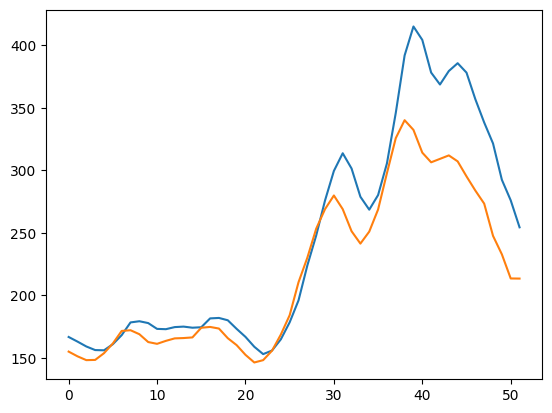

In [159]:
stock = 'ADM'
commodity = 'Corn'
lag = 1
forward = 0
reverse = False
model, scaler_stock, scaler_commodity, predictions, X_train, X_test, Y_train, Y_test, date = train_lstm(stock, commodity, lag, forward, reverse=reverse)
Y = np.concatenate((Y_train, Y_test), axis=0)
X = np.concatenate((X_train, X_test), axis=0)
predictions = model.predict(X)

if(reverse):
  Y= scaler_stock.inverse_transform(Y.reshape(-1, 1))
  predictions = scaler_stock.inverse_transform(predictions)
else:
  Y= scaler_commodity.inverse_transform(Y.reshape(-1, 1))
  predictions = scaler_commodity.inverse_transform(predictions)
df_tmp = pd.DataFrame({"Predictions": predictions.reshape(-1), "Labels": Y.reshape(-1)}, index=date[(lag+forward):])
ln = px.line(df_tmp, y=["Predictions", "Labels"])



ln.add_shape(
    # Line Vertical
    type="line",
    x0=df_tmp.index[X_train.shape[0]],
    y0=0,
    x1=df_tmp.index[X_train.shape[0]],
    y1=400,
    line=dict(
        color="darkseagreen",
        width=2,
        dash="dash",
    ),
)

ln.add_trace(go.Scatter(
    x=[None], y=[None],
    mode='lines',
    line=dict(color='darkseagreen', width=2, dash='dash'),
    showlegend=True,
    name="Train/Test Split"
))
ln.show()



In [150]:
px.line(all_stock_data['ADM'], y = "Close")

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [ ]:
ln.write_image("ADM.png", scale=6)

In [ ]:
# From Reuters
'''
Archer-Daniels-Midland Company is a human and animal nutrition company.
The Company is an agricultural supply chain manager and processor.
It operates through three business segments: Ag Services and Oilseeds, Carbohydrate Solutions, and Nutrition.
The Ag Services and Oilseeds segment includes global activities related to the origination, merchandising, transportation, and storage of agricultural raw materials, and the crushing and further processing of oilseeds such as soybeans and soft seeds into vegetable oils and protein meals.
The Carbohydrate Solutions segment is engaged in corn and wheat wet and dry milling and other activities.
The Nutrition segment is engaged in the manufacturing, sale, and distribution of a range of ingredients and solutions, including plant-based proteins, natural flavors, flavor systems, natural colors, emulsifiers, soluble fiber, polyols, hydrocolloids, probiotics, prebiotics, enzymes, botanical extracts, and other specialty food and feed ingredients.

Has a very high predictive power for corn
'''

'''
DE (John Deere) also has high predictive power for corn.
'''

In [ ]:
dollar_df = pd.read_csv('/content/nanda_dollar_tract_2003-2017_01P.csv')

In [ ]:
def get_state_from_fips(fips_code):
    fips_code = str(fips_code)
    state_fips_mapping = {
    "01": "AL",  # Alabama
    "02": "AK",  # Alaska
    "04": "AZ",  # Arizona
    "05": "AR",  # Arkansas
    "06": "CA",  # California
    "08": "CO",  # Colorado
    "09": "CT",  # Connecticut
    "10": "DE",  # Delaware
    "11": "DC",  # District of Columbia
    "12": "FL",  # Florida
    "13": "GA",  # Georgia
    "15": "HI",  # Hawaii
    "16": "ID",  # Idaho
    "17": "IL",  # Illinois
    "18": "IN",  # Indiana
    "19": "IA",  # Iowa
    "20": "KS",  # Kansas
    "21": "KY",  # Kentucky
    "22": "LA",  # Louisiana
    "23": "ME",  # Maine
    "24": "MD",  # Maryland
    "25": "MA",  # Massachusetts
    "26": "MI",  # Michigan
    "27": "MN",  # Minnesota
    "28": "MS",  # Mississippi
    "29": "MO",  # Missouri
    "30": "MT",  # Montana
    "31": "NE",  # Nebraska
    "32": "NV",  # Nevada
    "33": "NH",  # New Hampshire
    "34": "NJ",  # New Jersey
    "35": "NM",  # New Mexico
    "36": "NY",  # New York
    "37": "NC",  # North Carolina
    "38": "ND",  # North Dakota
    "39": "OH",  # Ohio
    "40": "OK",  # Oklahoma
    "41": "OR",  # Oregon
    "42": "PA",  # Pennsylvania
    "44": "RI",  # Rhode Island
    "45": "SC",  # South Carolina
    "46": "SD",  # South Dakota
    "47": "TN",  # Tennessee
    "48": "TX",  # Texas
    "49": "UT",  # Utah
    "50": "VT",  # Vermont
    "51": "VA",  # Virginia
    "53": "WA",  # Washington
    "54": "WV",  # West Virginia
    "55": "WI",  # Wisconsin
    "56": "WY",  # Wyoming
    "60": "AS",  # American Samoa
    "66": "GU",  # Guam
    "69": "MP",  # Northern Mariana Islands
    "72": "PR",  # Puerto Rico
    "78": "VI"   # Virgin Islands
    }

    return state_fips_mapping.get(fips_code)

In [ ]:
def get_first_two_digits(number):
    number_str = str(number)
    return number_str[:2]
dollar_df['tract_fips10'] = dollar_df['tract_fips10'].apply(get_first_two_digits)
dollar_df['State'] = dollar_df['tract_fips10'].apply(get_state_from_fips)
full_index = pd.Index(range(dollar_df.index.min(), dollar_df.index.max() + 1))
dollar_df = dollar_df.reindex(full_index)
dollar_df = dollar_df.interpolate()
dollar_df.drop(['tract_fips10'], axis=1, inplace=True)
dollar_df

In [ ]:
state_dollar_ag = dollar_df.groupby(['State', 'year']).sum()

In [ ]:
state_dollar_ag['ratio'] = state_dollar_ag['count_452319'] / state_dollar_ag['population']

In [ ]:
state_dollar_ag = state_dollar_ag.reset_index()

In [ ]:
state_dollar_ag

In [ ]:
state_dollar_ag.to_csv('state_dollar_ag.csv')

In [ ]:
pct_changes = {}
for state in state_dollar_ag['State']:
  pct_changes[state] = state_dollar_ag[state_dollar_ag['State'] == state]['count_452319'].pct_change(periods=state_dollar_ag[state_dollar_ag['State'] == state]['count_452319'].shape[0] - 1).dropna().sum()

In [ ]:
chg = pd.DataFrame.from_dict(pct_changes, orient='index', columns=['chg'])

In [ ]:
import plotly.express as px

fig = px.choropleth(chg,
                    locations=chg.index,
                    locationmode='USA-states',
                    color='chg',
                    hover_name='chg',
                    scope='usa',
                    labels={'chg': 'chg'},
                    title='Choropleth Map of All States Plus DC')

# # Add Puerto Rico manually
# fig.add_choropleth(locations=['PR'],
#                    locationmode='USA-states',
#                    z=[df[df['State'] == 'Puerto Rico']['Corr'].values[0]],
#                    colorscale='Viridis')

fig.show()
